# Student Project Tutorial Notebook (Exact Replica of Original Scripts)

This notebook reproduces the workflow of the original Python scripts exactly:

- `cloud_fraction.py`
- `analysis_of_data.py`
- `analysis_of_data_by_region.py`
- `analysis_map3.py`
- `analysis_of_data_by_region_correlations.py`

All outputs (figures, maps, tables) are shown inline.

Exports are saved as:

- `global_means.csv`
- `regional_means.csv`
- `oni_regional_correlation.csv`

---

## Setup & Imports

In [4]:
import glob, re, calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import warnings
from cartopy.io import DownloadWarning
warnings.filterwarnings("ignore", category=DownloadWarning)

%matplotlib inline
sns.set(style="whitegrid", context="notebook")

## 1. Global Cloud Fraction (from `cloud_fraction.py`)

Saved table → results/cloud_tcwv_globals_ERA5_2005_2025.csv
Saved plot → plots/cloud_tcwv_timeseries_2005_2025.png


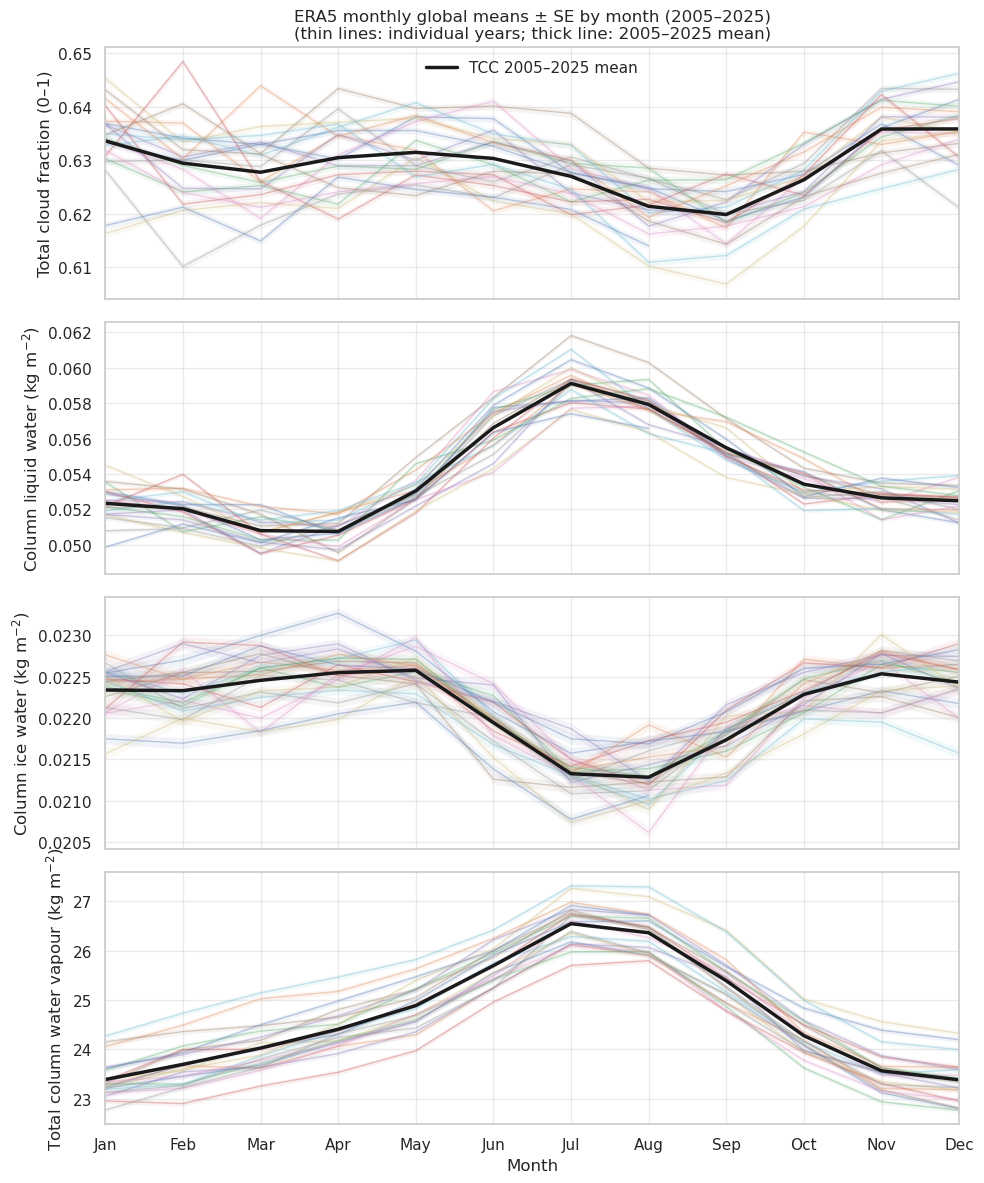

In [5]:
#!/usr/bin/env python3
"""
ERA5 single-level monthly means (2005–2025):
Global area-weighted means + standard error for
- tcc  (total cloud fraction, 0..1)
- tclw (total column cloud liquid water, kg m^-2)
- tciw (total column cloud ice water, kg m^-2)
- tcwv (total column water vapour, kg m^-2)

Outputs:
  results/cloud_tcwv_globals_ERA5_2005_2025.csv
  plots/cloud_tcwv_timeseries_2005_2025.png
"""


# ---------------- config ----------------
YEAR_START, YEAR_END = 2005, 2025
indir = Path("era5_monthly_nc")
patterns = [f"era5_single_levels_monthly_{y}*.nc" for y in range(YEAR_START, YEAR_END + 1)]

outdir_img = Path("plots");  outdir_img.mkdir(exist_ok=True)
outdir_tab = Path("results"); outdir_tab.mkdir(exist_ok=True)

# Candidate names (short + long to be robust)
VAR_CANDS = {
    "tcc":   ["tcc", "total_cloud_cover"],
    "tclw":  ["tclw", "total_column_cloud_liquid_water"],
    "tciw":  ["tciw", "total_column_cloud_ice_water"],
    "tcwv":  ["tcwv", "total_column_water_vapour", "total_column_water_vapor"],
}
LAT_CANDS  = ["latitude", "lat"]
LON_CANDS  = ["longitude", "lon"]
TIME_CANDS = ["valid_time", "time"]  # valid_time preferred (seconds since 1970-01-01)

# -------------- helpers -----------------
def pick_first_present(nc, candidates):
    for v in candidates:
        if v in nc.variables:
            return v
    return None

def area_weights(lats, lons):
    """cos(lat) weights broadcast to (lat, lon)."""
    wlat = np.cos(np.deg2rad(np.asarray(lats)))
    return np.repeat(wlat[:, None], len(lons), axis=1)

def weighted_mean_se(data2d, w2d):
    """Area-weighted mean and standard error over lat/lon."""
    m = np.isfinite(data2d)
    if not np.any(m):
        return np.nan, np.nan
    w = w2d * m
    wsum = w.sum()
    if wsum == 0:
        return np.nan, np.nan
    wnorm = w / wsum
    mean = np.nansum(data2d * wnorm)
    var  = np.nansum(wnorm * (data2d - mean)**2)
    Neff = 1.0 / np.nansum(wnorm**2)
    se   = np.sqrt(var) / np.sqrt(Neff)
    return mean, se

# -------------- read all files ----------
files = sorted({f for pat in patterns for f in glob.glob(str(indir / pat))})
if not files:
    raise FileNotFoundError(f"No files found in {indir} for {YEAR_START}-{YEAR_END}")

records = []

for f in files:
    with Dataset(f) as nc:
        lat_name = pick_first_present(nc, LAT_CANDS)
        lon_name = pick_first_present(nc, LON_CANDS)
        if lat_name is None or lon_name is None:
            raise KeyError(f"lat/lon not found in {f}. Vars: {list(nc.variables)}")

        lats = np.array(nc.variables[lat_name][:], dtype=float)
        lons = np.array(nc.variables[lon_name][:], dtype=float)
        w2d  = area_weights(lats, lons)

        time_name = pick_first_present(nc, TIME_CANDS)
        if time_name is None:
            raise KeyError(f"No valid time variable in {f} (looked for {TIME_CANDS})")

        tvals = np.asarray(nc.variables[time_name][:], dtype="int64")
        times = pd.to_datetime(tvals, unit="s", utc=True).tz_localize(None)

        names = {k: pick_first_present(nc, v) for k, v in VAR_CANDS.items()}

        for it, t in enumerate(times):
            if not (YEAR_START <= t.year <= YEAR_END):
                continue
            row = {"year": t.year, "month": t.month}
            for key, vname in names.items():
                if vname is None:
                    row[f"{key}_mean"] = np.nan
                    row[f"{key}_se"]   = np.nan
                    continue
                arr = np.array(nc.variables[vname][...], dtype=float)
                # arr can be (time, lat, lon) or (lat, lon)
                if arr.ndim == 3:
                    data2d = arr[it, ...]
                elif arr.ndim == 2:
                    if it > 0:
                        # single slice in file; but loop thinks there are multiple times
                        # be safe and reuse (common in monthly-mean files is one timestep)
                        data2d = arr
                    else:
                        data2d = arr
                else:
                    # unexpected shape
                    row[f"{key}_mean"] = np.nan
                    row[f"{key}_se"]   = np.nan
                    continue
                mean, se = weighted_mean_se(data2d, w2d)
                row[f"{key}_mean"] = mean
                row[f"{key}_se"]   = se
            records.append(row)

# -------------- tidy & merge dup months ---
df = pd.DataFrame.from_records(records)
# If multiple files contain the same (year,month), average them:
df = df.groupby(["year", "month"], as_index=True).mean(numeric_only=True).sort_index()

# Save table
csv_path = outdir_tab / f"cloud_tcwv_globals_ERA5_{YEAR_START}_{YEAR_END}.csv"
df.to_csv(csv_path, float_format="%.6g")
print(f"Saved table → {csv_path}")

# -------------- prep plotting -------------
months = np.arange(1, 12 + 1)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
years = list(range(YEAR_START, YEAR_END + 1))

def get_series(df, var, year):
    idx = pd.MultiIndex.from_product([[year], months], names=["year","month"])
    s_mean = df.get(f"{var}_mean")
    s_se   = df.get(f"{var}_se")
    if s_mean is None or s_se is None:
        return np.full(12, np.nan), np.full(12, np.nan)
    s_mean = s_mean.reindex(idx)
    s_se   = s_se.reindex(idx)
    return s_mean.values, s_se.values

def monthly_mean_over_years(df, var):
    """Mean across years for each month (uses available years only)."""
    s = df[f"{var}_mean"].unstack(level=0)  # index=month, columns=year
    # ensure months 1..12 are present as index, reindex if needed
    s = s.reindex(index=months)
    return np.array(s.mean(axis=1, skipna=True))

# -------------- plotting ------------------
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

series_meta = [
    ("tcc",  "Total cloud fraction (0–1)"),
    ("tclw", "Column liquid water (kg m$^{-2}$)"),
    ("tciw", "Column ice water (kg m$^{-2}$)"),
    ("tcwv", "Total column water vapour (kg m$^{-2}$)"),
]

for ax, (key, ylabel) in zip(axes, series_meta):
    # light spaghetti of all years
    for yr in years:
        y_mean, y_se = get_series(df, key, yr)
        ax.plot(months, y_mean, lw=1.0, alpha=0.35)
        # SE bands per year (optional; comment out if too busy)
        if np.isfinite(y_se).any():
            ax.fill_between(months, y_mean - y_se, y_mean + y_se, alpha=0.08)
    # multi-year monthly mean (bold)
    clim_line = monthly_mean_over_years(df, key)
    ax.plot(months, clim_line, lw=2.5, color="k", label=f"{key.upper()} 2005–2025 mean")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.4)
    ax.set_xlim(1, 12)
    ax.set_xticks(months)
    ax.set_xticklabels(month_labels)

axes[0].set_title("ERA5 monthly global means ± SE by month (2005–2025)\n(thin lines: individual years; thick line: 2005–2025 mean)")
axes[-1].set_xlabel("Month")
axes[0].legend(frameon=False)

fig.tight_layout()
png_path = outdir_img / f"cloud_tcwv_timeseries_{YEAR_START}_{YEAR_END}.png"
plt.savefig(png_path, dpi=150)
print(f"Saved plot → {png_path}")


## 2. Global Maps (from `analysis_map3.py`)

Saved tcc_mean_2005_2025.png
Saved tcc_elnino_minus_lanina_2005_2025.png
Saved tcc_oni_correlation_2005_2025.png


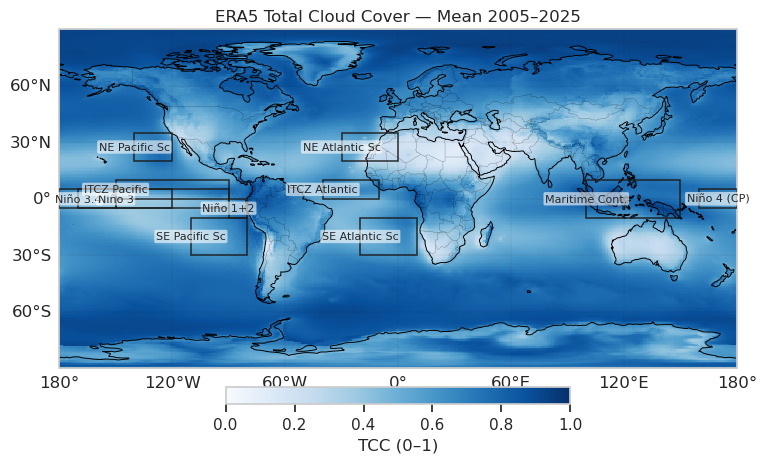

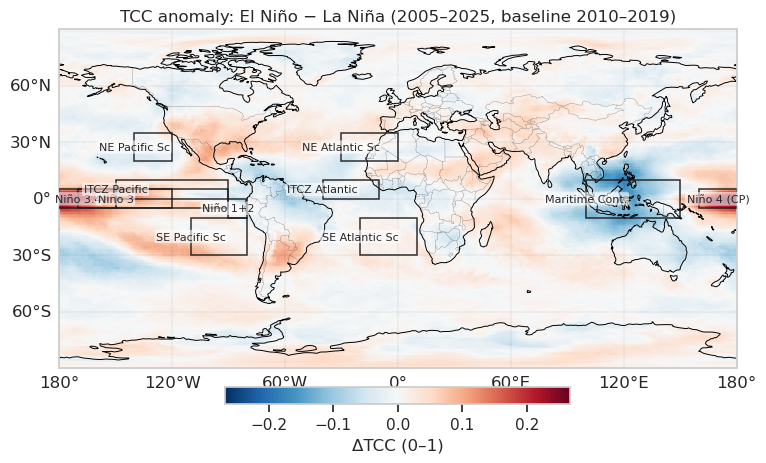

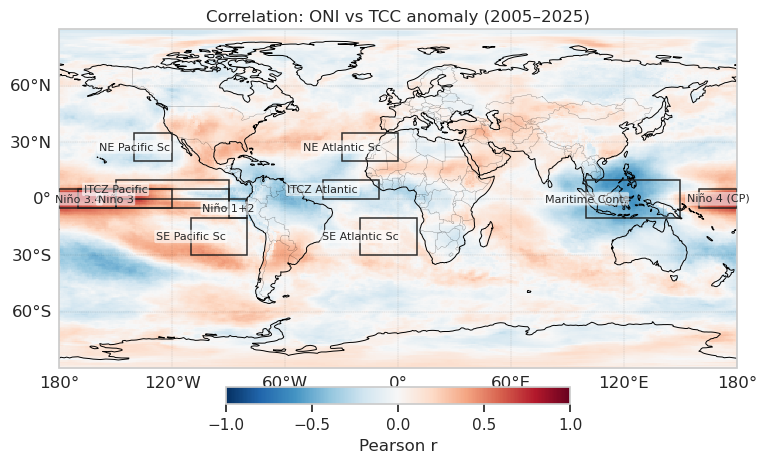

In [16]:
#!/usr/bin/env python3
"""
Global ERA5 TCC maps with coastlines + region overlays

Maps:
  1) Mean Total Cloud Cover (TCC)
  2) El Niño − La Niña composite (TCC anomalies)
  3) Correlation (ONI vs TCC anomalies)

Overlays:
  - Named rectangular regions used in earlier analysis (Niño boxes, stratocumulus regions, Maritime Continent, …)
    Longitudes are in −180..180. Dateline-crossing boxes are handled automatically.

Inputs:
  - NetCDFs: era5_single_levels_monthly_YYYYMM.nc with:
      tcc/total_cloud_cover, latitude/longitude, valid_time (seconds since 1970-01-01)
      optional land_sea_mask/lsm (for pseudo-coastline fallback if Cartopy absent)
  - oni.csv: two columns (Date, ONI). Duplicate headers ok; -9999 treated as missing.
"""

import glob, os, numpy as np, pandas as pd
from pathlib import Path
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# =========================
# CONFIG — edit these only
# =========================
ANALYSIS_START = 2005
ANALYSIS_END   = 2025

CLIM_START     = 2010   # baseline for anomalies
CLIM_END       = 2019
ENSO_THRESH    = 0.5    # ONI threshold for El Niño/La Niña

DATA_DIR       = Path("era5_monthly_nc")
ONI_CSV        = "oni.csv"

VAR_CANDS      = ["tcc", "total_cloud_cover"]
LAT_CANDS      = ["latitude", "lat"]
LON_CANDS      = ["longitude", "lon"]
TIME_CANDS     = ["valid_time", "time"]
LSM_CANDS      = ["land_sea_mask", "lsm"]  # optional

# === Regions to draw (latS, latN, lonW, lonE) in −180..180 ===
REGIONS = {
    # ENSO / Tropical Pacific
    "Niño 3.4":         (-5,   5,  -170, -120),
    "Niño 3":           (-5,   5,  -150,  -90),
    "Niño 4 (CP)":      (-5,   5,   160,  -150),   # crosses dateline
    "Niño 1+2":         (-10,  0,   -90,  -80),

    # Maritime Continent
    "Maritime Cont.":   (-10, 10,   100,   150),

    # Marine stratocumulus decks
    "SE Pacific Sc":    (-30, -10,  -110,  -80),
    "SE Atlantic Sc":   (-30, -10,   -20,   10),
    "NE Pacific Sc":    ( 20,  35,  -140, -120),
    "NE Atlantic Sc":   ( 20,  35,   -30,    0),

    # ITCZ sample boxes
    "ITCZ Pacific":     (  0,  10,  -150,  -90),
    "ITCZ Atlantic":    (  0,  10,   -40,  -10),
}

# =========================
# Helpers
# =========================
def pick_var(nc, cands):
    for v in cands:
        if v in nc.variables:
            return v
    return None

def to_lon180(lon):
    lon180 = (lon + 180.0) % 360.0 - 180.0
    order = np.argsort(lon180)
    return lon180[order], order

def get_time(nc, tname):
    tsec = np.asarray(nc.variables[tname][:], dtype="int64")
    return pd.to_datetime(tsec, unit="s", utc=True).tz_localize(None)

def try_import_cartopy():
    try:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        return ccrs, cfeature
    except Exception:
        return None, None

def _region_segments(lw, le):
    """Return non-wrapping lon segments in −180..180 for a box; split if crossing dateline."""
    if lw <= le:
        return [(lw, le)]
    # wrap: e.g., 160 .. -150  -> (160..180) & (-180..-150)
    return [(lw, 180.0), (-180.0, le)]

def _draw_regions(ax, regions, use_cartopy=False, transform=None):
    """Draw region rectangles + labels on current axes."""
    if not regions:
        return
    for name, (latS, latN, lonW, lonE) in regions.items():
        segs = _region_segments(lonW, lonE)
        for lw, le in segs:
            width = le - lw
            height = latN - latS
            rect = Rectangle((lw, latS), width, height,
                             fill=False, lw=1.1, ec="k", ls="-", alpha=0.9,
                             transform=transform if use_cartopy else None, zorder=5)
            ax.add_patch(rect)
        # Label at (center lon, center lat); if wrapped, place label near middle of first segment
        cx = lonW if lonW <= lonE else ( (lonW + 180)/2 )  # simple choice; cartopy handles wrap
        cy = 0.5*(latS + latN)
        ax.text(cx, cy, name,
                ha="center", va="center", fontsize=8,
                bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.6),
                transform=transform if use_cartopy else None, zorder=6)

def plot_map(data2d, lon, lat, title, cmap, vmin=None, vmax=None, cb_label="",
             fname="map.png", lsm2d=None, regions=None):
    """
    Plot with Cartopy if available; otherwise fallback with optional LSM pseudo-coastline.
    data2d shape: [lat, lon] with lon in -180..180 ascending and lat ascending.
    """
    Lon2, Lat2 = np.meshgrid(lon, lat)
    ccrs, cfeature = try_import_cartopy()

    if ccrs is not None:
        proj = ccrs.PlateCarree()
        fig = plt.figure(figsize=(10, 4.8))
        ax = plt.axes(projection=proj)
        im = ax.pcolormesh(Lon2, Lat2, data2d, transform=proj, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.coastlines(resolution="110m", linewidth=0.7)
        ax.add_feature(cfeature.BORDERS.with_scale("110m"), linewidth=0.3, alpha=0.4)
        gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="k", alpha=0.25, linestyle="--")
        gl.top_labels = gl.right_labels = False
        ax.set_global()
        # Regions
        _draw_regions(ax, regions, use_cartopy=True, transform=proj)
        cb = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, fraction=0.046)
        cb.set_label(cb_label)
        ax.set_title(title)
        plt.tight_layout()
        plt.savefig(fname, dpi=140)
        # plt.close(fig)
        return

    # Fallback (no Cartopy): draw a pseudo-coastline if LSM provided and overlay regions
    fig, ax = plt.subplots(1, 1, figsize=(10, 4.8))
    im = ax.pcolormesh(Lon2, Lat2, data2d, cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")
    if lsm2d is not None:
        try:
            ax.contour(Lon2, Lat2, lsm2d, levels=[0.5], colors="k", linewidths=0.5)
        except Exception:
            pass
    ax.set_xlim([-180, 180]); ax.set_ylim([lat.min(), lat.max()])
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    # Regions (plain axes)
    _draw_regions(ax, regions, use_cartopy=False, transform=None)
    cb = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.08)
    cb.set_label(cb_label)
    ax.set_title(title + " (fallback: pseudo-coastline from LSM)")
    ax.grid(True, alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.savefig(fname, dpi=140)
    # plt.close(fig)

def corr_along_time(x, ytx):
    """Pearson r per grid cell; x: [T], ytx: [T,Y,X]"""
    x = np.asarray(x, dtype=float)
    T, NY, NX = ytx.shape
    r = np.full((NY, NX), np.nan)
    for j in range(NY):
        for i in range(NX):
            y = ytx[:, j, i].astype(float)
            mask = np.isfinite(x) & np.isfinite(y)
            n = int(mask.sum())
            if n < 3:
                continue
            xi = x[mask] - np.nanmean(x[mask])
            yi = y[mask] - np.nanmean(y[mask])
            sx = np.nanstd(xi, ddof=1); sy = np.nanstd(yi, ddof=1)
            if sx == 0 or sy == 0:
                continue
            r[j, i] = np.nansum(xi * yi) / ((n - 1) * sx * sy)
    return r

# =========================
# Gather files & read grid
# =========================
patterns = [f"era5_single_levels_monthly_{y}*.nc" for y in range(ANALYSIS_START, ANALYSIS_END + 1)]
files = sorted({f for pat in patterns for f in glob.glob(str(DATA_DIR / pat))})
if not files:
    raise FileNotFoundError(f"No NetCDF files found in {DATA_DIR} for {ANALYSIS_START}-{ANALYSIS_END}")

with Dataset(files[0]) as nc0:
    vlat = pick_var(nc0, LAT_CANDS); vlon = pick_var(nc0, LON_CANDS)
    if vlat is None or vlon is None:
        raise KeyError("latitude/longitude not found in the first file.")
    lat = np.array(nc0.variables[vlat][:], dtype=float)
    lon = np.array(nc0.variables[vlon][:], dtype=float)

    # Ensure lat ascending
    flip_lat = False
    if lat[0] > lat[-1]:
        lat = lat[::-1]
        flip_lat = True

    lon180, order_lon = to_lon180(lon)

    # Optional land-sea mask for pseudo-coastlines
    vlsm = pick_var(nc0, LSM_CANDS)
    lsm180 = None
    if vlsm is not None:
        lsm = np.array(nc0.variables[vlsm][...], dtype=float)
        if lsm.ndim == 3:  # singleton time dimension sometimes present
            lsm = lsm[0, ...]
        if flip_lat:
            lsm = lsm[::-1, :]
        lsm180 = lsm[:, order_lon]

# =========================
# Read TCC time series
# =========================
times = []
tcc_list = []
for f in files:
    with Dataset(f) as nc:
        tname = pick_var(nc, TIME_CANDS)
        vname = pick_var(nc, VAR_CANDS)
        if tname is None or vname is None:
            continue
        tt = get_time(nc, tname)
        arr = np.array(nc.variables[vname][...], dtype=float)  # (t,y,x) or (y,x)
        if arr.ndim == 2: arr = arr[None, ...]
        if flip_lat:       arr = arr[:, ::-1, :]
        arr = arr[:, :, order_lon]
        times.extend(list(tt))
        tcc_list.append(arr)

if not tcc_list:
    raise RuntimeError("No TCC data found in the files.")
tcc = np.concatenate(tcc_list, axis=0)  # [T, Y, X]
time_index = pd.to_datetime(times)

# Keep requested window
mask_time = (time_index.year >= ANALYSIS_START) & (time_index.year <= ANALYSIS_END)
tcc = tcc[mask_time, :, :]
time_index = time_index[mask_time]

# =========================
# Climatology & anomalies
# =========================
df_time = pd.DataFrame({"y": time_index.year, "m": time_index.month})
mask_clim = (df_time["y"] >= CLIM_START) & (df_time["y"] <= CLIM_END)

clim = np.full((12, tcc.shape[1], tcc.shape[2]), np.nan, dtype=float)
for m in range(1, 13):
    sel = (df_time["m"].values == m) & mask_clim.values
    if np.any(sel):
        clim[m - 1] = np.nanmean(tcc[sel, :, :], axis=0)

anom = np.empty_like(tcc)
for i, m in enumerate(df_time["m"].values):
    anom[i] = tcc[i] - clim[m - 1]

# =========================
# ONI & ENSO masks
# =========================
oni_raw = pd.read_csv(ONI_CSV, header=None, names=["date", "oni"])
oni_raw["date"] = pd.to_datetime(oni_raw["date"], format="%Y-%m-%d",errors="coerce")
oni_raw["oni"]  = pd.to_numeric(oni_raw["oni"], errors="coerce")
oni = oni_raw.dropna(subset=["date"]).copy()
oni.loc[oni["oni"] <= -99, "oni"] = np.nan
oni["year"] = oni["date"].dt.year
oni["month"] = oni["date"].dt.month
oni = oni.set_index(["year", "month"]).sort_index()

key = list(zip(df_time["y"].tolist(), df_time["m"].tolist()))
oni_aligned = oni.reindex(key)["oni"].to_numpy()
elnino_mask = (oni_aligned >=  ENSO_THRESH)
lanina_mask = (oni_aligned <= -ENSO_THRESH)

# =========================
# (1) Mean TCC map
# =========================
tcc_mean = np.nanmean(tcc, axis=0)
plot_map(
    data2d=tcc_mean, lon=lon180, lat=lat,
    title=f"ERA5 Total Cloud Cover — Mean {ANALYSIS_START}–{ANALYSIS_END}",
    cmap="Blues", vmin=0.0, vmax=1.0, cb_label="TCC (0–1)",
    fname=f"tcc_mean_{ANALYSIS_START}_{ANALYSIS_END}.png",
    lsm2d=lsm180, regions=REGIONS
)
print(f"Saved tcc_mean_{ANALYSIS_START}_{ANALYSIS_END}.png")

# =========================
# (2) El Niño − La Niña composite (anomalies)
# =========================
eln = np.nanmean(anom[elnino_mask, :, :], axis=0) if np.any(elnino_mask) else np.full_like(tcc_mean, np.nan)
lan = np.nanmean(anom[lanina_mask, :, :], axis=0) if np.any(lanina_mask) else np.full_like(tcc_mean, np.nan)
comp = eln - lan
vmax = max(0.1, float(np.nanmax(np.abs(comp))) if np.isfinite(comp).any() else 0.1)
plot_map(
    data2d=comp, lon=lon180, lat=lat,
    title=f"TCC anomaly: El Niño − La Niña ({ANALYSIS_START}–{ANALYSIS_END}, baseline {CLIM_START}–{CLIM_END})",
    cmap="RdBu_r", vmin=-vmax, vmax=+vmax, cb_label="ΔTCC (0–1)",
    fname=f"tcc_elnino_minus_lanina_{ANALYSIS_START}_{ANALYSIS_END}.png",
    lsm2d=lsm180, regions=REGIONS
)
print(f"Saved tcc_elnino_minus_lanina_{ANALYSIS_START}_{ANALYSIS_END}.png")

# =========================
# (3) Correlation map: ONI vs TCC anomalies
# =========================
valid_t = np.isfinite(oni_aligned)
Xv = oni_aligned[valid_t]
Yv = anom[valid_t, :, :]
rmap = corr_along_time(Xv, Yv)
plot_map(
    data2d=rmap, lon=lon180, lat=lat,
    title=f"Correlation: ONI vs TCC anomaly ({ANALYSIS_START}–{ANALYSIS_END})",
    cmap="RdBu_r", vmin=-1, vmax=1, cb_label="Pearson r",
    fname=f"tcc_oni_correlation_{ANALYSIS_START}_{ANALYSIS_END}.png",
    lsm2d=lsm180, regions=REGIONS
)
print(f"Saved tcc_oni_correlation_{ANALYSIS_START}_{ANALYSIS_END}.png")


## 3. Global Analysis (from `analysis_of_data.py`)

Saved global_means_2005_2025.csv
Saved anomalies_2005_2025.csv

Global-mean anomalies (2005-2025) relative to 2010-2019:
              tcc      tcwv
state                      
ElNino  -0.000635  0.284228
Neutral -0.002403 -0.049552
LaNina  -0.003675 -0.243160
Saved era5_global_anoms_by_ENSO_2005_2025.png


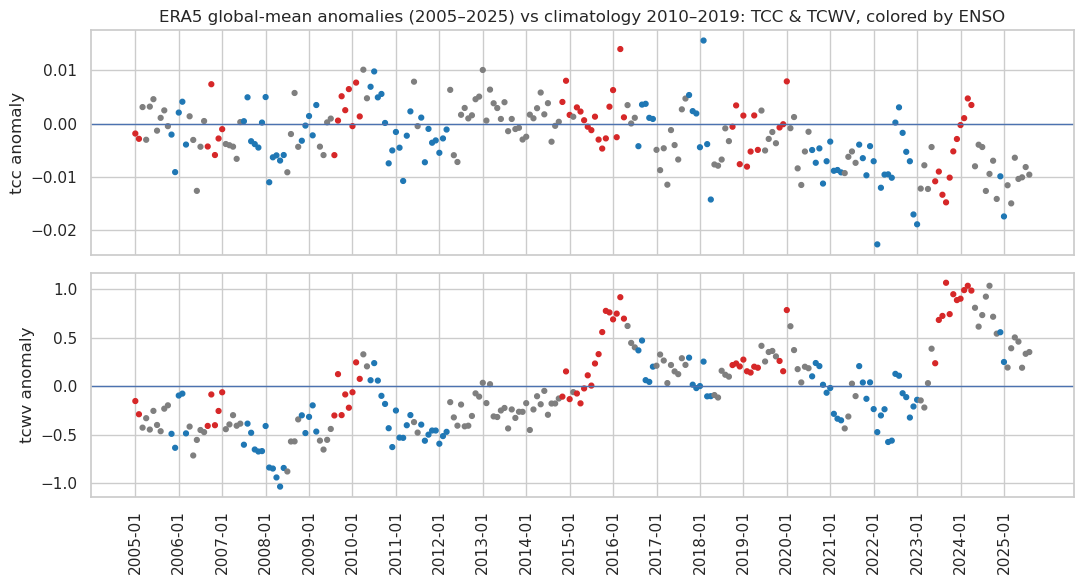

In [7]:
#!/usr/bin/env python3
"""
ERA5 global-mean anomalies for TCC & TCWV, coloured by ENSO.

Fixes:
- Remove duplicate 'year'/'month' columns after MultiIndex groupby.
- Use groupby(level="month") to avoid ambiguity.
- Parse ONI CSV with two columns ('Date','ONI'), drop headers, handle -9999.

Outputs:
- global_means_<FILE_START>_<FILE_END>.csv
- anomalies_<ANALYSIS_START>_<ANALYSIS_END>.csv
- era5_global_anoms_by_ENSO_<ANALYSIS_START>_<ANALYSIS_END>.png
- Printed El Niño / Neutral / La Niña composites
"""

import glob, numpy as np, pandas as pd
from pathlib import Path
from netCDF4 import Dataset
import matplotlib.pyplot as plt

# =========================
# CONFIG — edit these only
# =========================
ANALYSIS_START = 2005
ANALYSIS_END   = 2025

# Baseline for monthly climatology (used for anomalies)
CLIM_START = 2010
CLIM_END   = 2019

# ENSO threshold for ONI (°C)
ENSO_THRESH = 0.5

# Data location
indir = Path("era5_monthly_nc")
oni_csv = "oni.csv"   # two columns: Date, ONI

# Variables (single levels, monthly means)
vars_single = {
    "tcc":  ["tcc", "total_cloud_cover"],
    "tcwv": ["tcwv", "total_column_water_vapour", "total_column_water_vapor"],
}
LAT_CANDS, LON_CANDS, TIME_CANDS = ["latitude","lat"], ["longitude","lon"], ["valid_time","time"]

# =========================================================
# Helpers
# =========================================================
def pick(nc, candidates):
    for v in candidates:
        if v in nc.variables:
            return v
    return None

def area_weights(lat, lon):
    wlat = np.cos(np.deg2rad(lat))
    return np.broadcast_to(wlat[:, None], (len(lat), len(lon)))

def wmean(data2d, w2d):
    m = np.isfinite(data2d)
    w = w2d * m
    return np.nan if w.sum() == 0 else np.nansum(w * data2d) / np.nansum(w)

# =========================================================
# Build file list (include baseline years if outside analysis range)
# =========================================================
FILE_START = min(ANALYSIS_START, CLIM_START)
FILE_END   = max(ANALYSIS_END,   CLIM_END)
patterns = [f"era5_single_levels_monthly_{y}*.nc" for y in range(FILE_START, FILE_END+1)]

files = sorted({f for pat in patterns for f in glob.glob(str(indir / pat))})
if not files:
    raise FileNotFoundError(f"No files found in {indir} for {FILE_START}-{FILE_END}")

# =========================================================
# Read monthly global means
# =========================================================
rows = []
for f in files:
    with Dataset(f) as nc:
        la = pick(nc, LAT_CANDS); lo = pick(nc, LON_CANDS)
        if la is None or lo is None:
            raise KeyError(f"lat/lon not found in {f}. Have: {list(nc.variables)}")
        lat = nc.variables[la][:]; lon = nc.variables[lo][:]
        w2d = area_weights(lat, lon)

        tname = pick(nc, TIME_CANDS)
        if tname is None:
            raise KeyError(f"time variable not found in {f} (looked for {TIME_CANDS})")
        t = pd.to_datetime(np.asarray(nc.variables[tname][:], dtype="int64"),
                           unit="s", utc=True).tz_localize(None)

        names = {k: pick(nc, c) for k, c in vars_single.items()}

        for it, ts in enumerate(t):
            rec = {"time": ts, "year": ts.year, "month": ts.month}
            for k, vn in names.items():
                if vn is None:
                    rec[k] = np.nan
                else:
                    rec[k] = wmean(np.array(nc.variables[vn][it, ...], float), w2d)
            rows.append(rec)

df = pd.DataFrame(rows).set_index("time").sort_index()

# Average if duplicate monthly entries exist (e.g., multiple files with same month)
df = df.groupby([df.index.year, df.index.month]).mean()
df.index.names = ["year", "month"]

# Drop duplicate 'year'/'month' columns created by the aggregation
for col in ["year", "month"]:
    if col in df.columns:
        df = df.drop(columns=col)

# Save raw global means over full loaded span
full_means_csv = f"global_means_{FILE_START}_{FILE_END}.csv"
df.to_csv(full_means_csv, float_format="%.6g")
print(f"Saved {full_means_csv}")

# Keep only requested analysis years for outputs/plots
idx = pd.IndexSlice
df_in_range = df.loc[idx[ANALYSIS_START:ANALYSIS_END, 1:12], :]

# =========================================================
# Climatology (monthly) and anomalies
# =========================================================
clim_source = df.loc[idx[CLIM_START:CLIM_END, 1:12], :]
if clim_source.empty:
    print(f"Warning: No data for baseline {CLIM_START}-{CLIM_END}. "
          f"Using available years {FILE_START}-{FILE_END} as baseline instead.")
    clim_source = df

# IMPORTANT: group by index level (month), not a column
clim = clim_source.groupby(level="month")[["tcc", "tcwv"]].mean()

anom = df_in_range.copy()
for m in range(1, 13):
    if m in clim.index:
        anom.loc[idx[:, m], ["tcc", "tcwv"]] = (
            df_in_range.loc[idx[:, m], ["tcc", "tcwv"]].values
            - clim.loc[m, ["tcc", "tcwv"]].values
        )

# Save anomalies table
anom_csv = f"anomalies_{ANALYSIS_START}_{ANALYSIS_END}.csv"
anom.reset_index().to_csv(anom_csv, index=False, float_format="%.6g")
print(f"Saved {anom_csv}")

# =========================================================
# ONI: parse your two-column file ('Date','ONI')
# =========================================================
# The file may contain duplicate header lines and -9999 sentinels.
oni_raw = pd.read_csv(
    oni_csv,
    header=None,              # treat all rows as data
    names=["date", "oni"],    # name the two columns
)

# Coerce types; drop non-parsable header lines; clean sentinels
oni_raw["date"] = pd.to_datetime(oni_raw["date"], format="%Y-%m-%d",errors="coerce")
oni_raw["oni"]  = pd.to_numeric(oni_raw["oni"], errors="coerce")
oni = oni_raw.dropna(subset=["date"]).copy()
# Treat big negative sentinels as missing
oni.loc[oni["oni"] <= -99, "oni"] = np.nan

oni["year"]  = oni["date"].dt.year
oni["month"] = oni["date"].dt.month
oni = oni.set_index(["year", "month"]).sort_index()

# Align ONI to our anomaly index
oni_vals = oni.reindex(anom.index)["oni"]

# Label phases; keep NaNs as Neutral fallback
state = pd.Series(index=anom.index, dtype="string")
state[(oni_vals >=  ENSO_THRESH).fillna(False)] = "ElNino"
state[(oni_vals <= -ENSO_THRESH).fillna(False)] = "LaNina"
state[state.isna()] = "Neutral"

# =========================================================
# Composites (global-mean anomalies by ENSO phase)
# =========================================================
comp = (anom.join(state.rename("state"))
          .groupby("state")[["tcc", "tcwv"]].mean()
          .reindex(["ElNino", "Neutral", "LaNina"]))
print(f"\nGlobal-mean anomalies ({ANALYSIS_START}-{ANALYSIS_END}) "
      f"relative to {CLIM_START}-{CLIM_END}:")
print(comp)

# =========================================================
# Plot: monthly anomalies colored by ENSO state
# =========================================================
months_labels = [f"{y}-{m:02d}" for y, m in anom.index]
x = np.arange(len(months_labels))
colors = {"ElNino": "tab:red", "Neutral": "tab:gray", "LaNina": "tab:blue"}

fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharex=True)
for i, var in enumerate(["tcc", "tcwv"]):
    c = [colors.get(s, "k") for s in state.values]
    axes[i].scatter(x, anom[var].values, s=12, c=c)
    axes[i].axhline(0, lw=1)
    axes[i].set_ylabel(f"{var} anomaly")
    axes[i].grid(True)

# sensible tick density even for long ranges
step = max(1, len(x)//20)
axes[-1].set_xticks(x[::step])
axes[-1].set_xticklabels(months_labels[::step], rotation=90)

axes[0].set_title(f"ERA5 global-mean anomalies ({ANALYSIS_START}–{ANALYSIS_END}) "
                  f"vs climatology {CLIM_START}–{CLIM_END}: TCC & TCWV, colored by ENSO")
plt.tight_layout()
out_png = f"era5_global_anoms_by_ENSO_{ANALYSIS_START}_{ANALYSIS_END}.png"
plt.savefig(out_png, dpi=140)
print(f"Saved {out_png}")


## 3. Regional Analysis (from `analysis_of_data_by_region.py`)

Saved regional_means_2005_2025.csv
Saved regional_anomalies_2005_2025.csv

Regional mean TCC anomalies by ENSO phase:
          Nino3.4  MaritimeContinent  CentralPacific  E_Pac_Stratocu_S  \
state                                                                    
ElNino   0.072757          -0.055460        0.103239          0.006363   
Neutral -0.018330           0.004145       -0.016558         -0.008535   
LaNina  -0.050224           0.027912       -0.084529         -0.001438   

         NE_Pac_Stratocu_N  IndianEq  
state                                 
ElNino           -0.015094 -0.019241  
Neutral           0.011894 -0.000542  
LaNina            0.006814  0.005555  
Saved tcc_regional_anoms_2005_2025.png


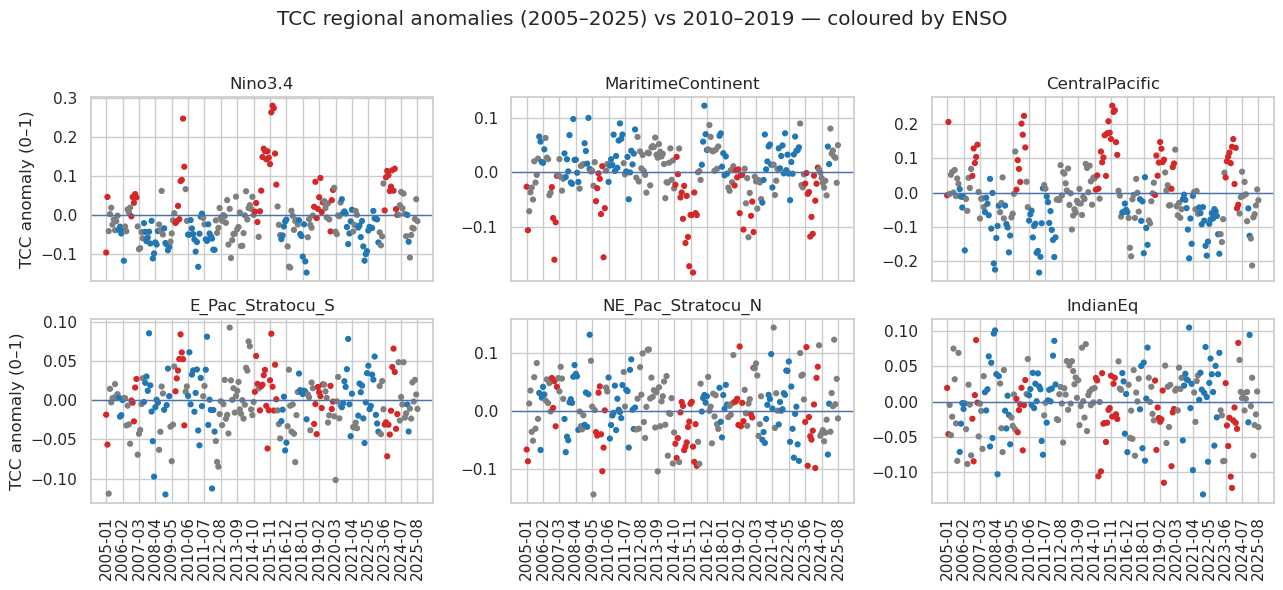

In [8]:
#!/usr/bin/env python3
"""
Regional ERA5 TCC anomalies (area-weighted) with ENSO colouring.

- Reads monthly single-level NetCDFs with 'valid_time' (seconds since 1970-01-01)
- Computes regional area-weighted monthly means of TCC
- Builds 2010–2019 monthly climatology (configurable) *per region*
- Produces anomalies for a chosen analysis window
- Colours points by ENSO state from an ONI CSV (two columns: Date, ONI)

Outputs:
  - CSVs: regional_means_*, regional_anomalies_*
  - PNG: tcc_regional_anoms_<start>_<end>.png
"""

import glob, numpy as np, pandas as pd
from pathlib import Path
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from math import ceil

# =========================
# CONFIG — edit these only
# =========================
ANALYSIS_START = 2005
ANALYSIS_END   = 2025

# Baseline for monthly climatology (used for anomalies)
CLIM_START = 2010
CLIM_END   = 2019

# ENSO threshold for ONI (°C)
ENSO_THRESH = 0.5

# If True and land_sea_mask/lsm is present, use OCEAN ONLY (lsm < 0.5)
OCEAN_ONLY = False

# NetCDF folder and ONI file (two columns: Date, ONI)
indir = Path("era5_monthly_nc")
oni_csv = "oni.csv"

# Variable/coord name candidates
VAR_TCC   = ["tcc", "total_cloud_cover"]
LAT_CANDS = ["latitude", "lat"]
LON_CANDS = ["longitude", "lon"]
TIME_CANDS= ["valid_time", "time"]
LSM_CANDS = ["land_sea_mask", "lsm"]  # fraction land (0 ocean, 1 land)

# Regions (lat_min, lat_max, lon_min, lon_max) — lon can be in −180..180 or 0..360
REGIONS = {
    "Nino3.4":            (-5,   5,  -170,  -120),  # 5S–5N, 170W–120W
    "MaritimeContinent":  (-10, 10,   100,   150),  # 10S–10N, 100E–150E
    "CentralPacific":     (-5,   5,   160,   -150), # 160E–150W (wrap)
    "E_Pac_Stratocu_S":   (-25, -5,  -100,   -80),  # SEP stratocu
    "NE_Pac_Stratocu_N":  (15,  30,  -140,  -120),  # NEP stratocu
    "IndianEq":           (-10, 10,    60,   100),  # Equatorial Indian
}
# =========================================================

def pick(nc, candidates):
    for v in candidates:
        if v in nc.variables:
            return v
    return None

def area_weights(lat, lon):
    wlat = np.cos(np.deg2rad(lat))
    return np.broadcast_to(wlat[:, None], (len(lat), len(lon)))

def to0360(lon_vals):
    return np.mod(lon_vals, 360.0)

def bounds_to_0360(lmin, lmax):
    return (lmin % 360.0, lmax % 360.0)

def lon_mask_0360(lon_axis_0360, lo0360, hi0360):
    # supports wrap-around (e.g., 350..20)
    if lo0360 <= hi0360:
        return (lon_axis_0360 >= lo0360) & (lon_axis_0360 <= hi0360)
    else:
        return (lon_axis_0360 >= lo0360) | (lon_axis_0360 <= hi0360)

def region_mask(lat, lon, lat_min, lat_max, lon_min, lon_max):
    """2D boolean mask for region bounds. Handles lon wrap and lon conventions."""
    # Ensure increasing bounds
    la0, la1 = (lat_min, lat_max) if lat_min <= lat_max else (lat_max, lat_min)
    lat_m = (lat >= la0) & (lat <= la1)

    # Put lon axis and bounds into 0..360 for robust selection
    lon0360 = to0360(lon.copy())
    lo0360, hi0360 = bounds_to_0360(lon_min, lon_max)
    lon_m = lon_mask_0360(lon0360, lo0360, hi0360)

    return lat_m[:, None] & lon_m[None, :]

def weighted_mean_region(data2d, w2d, mask2d):
    mask = np.isfinite(data2d) & mask2d
    if not np.any(mask):
        return np.nan
    w = w2d * mask
    return np.nansum(w * data2d) / np.nansum(w)

# -------------------------------
# Build file list (include clim years)
# -------------------------------
FILE_START = min(ANALYSIS_START, CLIM_START)
FILE_END   = max(ANALYSIS_END,   CLIM_END)
patterns = [f"era5_single_levels_monthly_{y}*.nc" for y in range(FILE_START, FILE_END+1)]
files = sorted({f for pat in patterns for f in glob.glob(str(indir / pat))})
if not files:
    raise FileNotFoundError(f"No files in {indir} for {FILE_START}-{FILE_END}")

# -------------------------------
# Loop files → regional means
# -------------------------------
records = []
for f in files:
    with Dataset(f) as nc:
        vlat = pick(nc, LAT_CANDS); vlon = pick(nc, LON_CANDS)
        if vlat is None or vlon is None:
            raise KeyError(f"lat/lon not found in {f}")
        lat = np.array(nc.variables[vlat][:], dtype=float)
        lon = np.array(nc.variables[vlon][:], dtype=float)
        w2d = area_weights(lat, lon)

        # Optional ocean-only mask
        ocean_mask = None
        if OCEAN_ONLY:
            vlsm = pick(nc, LSM_CANDS)
            if vlsm is not None:
                lsm = np.array(nc.variables[vlsm][...], dtype=float)
                # Make 2D
                if lsm.ndim == 3:
                    lsm = lsm[0, ...]
                ocean_mask = (lsm < 0.5)

        # Precompute region masks for this grid
        region_masks = {}
        for rname, (la0, la1, lo0, lo1) in REGIONS.items():
            m = region_mask(lat, lon, la0, la1, lo0, lo1)
            if OCEAN_ONLY and ocean_mask is not None:
                m = m & ocean_mask
            region_masks[rname] = m

        # Time and TCC var
        vtime = pick(nc, TIME_CANDS)
        if vtime is None:
            raise KeyError(f"time var not found in {f} (looked for {TIME_CANDS})")
        times = pd.to_datetime(np.asarray(nc.variables[vtime][:], dtype="int64"),
                               unit="s", utc=True).tz_localize(None)

        vtcc = pick(nc, VAR_TCC)
        if vtcc is None:
            raise KeyError(f"TCC not found in {f} (candidates {VAR_TCC})")

        for it, ts in enumerate(times):
            rec = {"time": ts, "year": ts.year, "month": ts.month}
            tcc2d = np.array(nc.variables[vtcc][it, ...], dtype=float)
            for rname, m in region_masks.items():
                rec[f"{rname}"] = weighted_mean_region(tcc2d, w2d, m)
            records.append(rec)

# -------------------------------
# Tidy to MultiIndex table
# -------------------------------
df = pd.DataFrame.from_records(records).set_index("time").sort_index()
# average duplicates if any
df = df.groupby([df.index.year, df.index.month]).mean()
df.index.names = ["year", "month"]
# drop any leftover 'year','month' columns from aggregation
for col in ("year", "month"):
    if col in df.columns:
        df = df.drop(columns=col)

# Save raw regional means (full span)
out_means = f"regional_means_{FILE_START}_{FILE_END}.csv"
df.to_csv(out_means, float_format="%.6g")
print(f"Saved {out_means}")

# -------------------------------
# Build anomalies per region
# -------------------------------
idx = pd.IndexSlice
df_in = df.loc[idx[ANALYSIS_START:ANALYSIS_END, 1:12], :]

clim_src = df.loc[idx[CLIM_START:CLIM_END, 1:12], :]
if clim_src.empty:
    print(f"WARNING: No data for baseline {CLIM_START}-{CLIM_END}. "
          f"Using available years {FILE_START}-{FILE_END} as baseline.")
    clim_src = df

anom = df_in.copy()
months = anom.index.get_level_values("month")

for col in df.columns:
    clim_month = clim_src[col].groupby(level="month").mean()
    # map month → climatology value for that region
    anom[col] = df_in[col].values - months.map(clim_month).values

# Save anomalies
out_anoms = f"regional_anomalies_{ANALYSIS_START}_{ANALYSIS_END}.csv"
anom.reset_index().to_csv(out_anoms, index=False, float_format="%.6g")
print(f"Saved {out_anoms}")

# -------------------------------
# ENSO labels from ONI (two columns: Date, ONI; some rows may be headers or -9999)
# -------------------------------
oni_raw = pd.read_csv(oni_csv, header=None, names=["date", "oni"])
oni_raw["date"] = pd.to_datetime(oni_raw["date"], format="%Y-%m-%d",errors="coerce")
oni_raw["oni"]  = pd.to_numeric(oni_raw["oni"], errors="coerce")
oni = oni_raw.dropna(subset=["date"]).copy()
oni.loc[oni["oni"] <= -99, "oni"] = np.nan  # treat sentinels as missing
oni["year"]  = oni["date"].dt.year
oni["month"] = oni["date"].dt.month
oni = oni.set_index(["year", "month"]).sort_index()

oni_vals = oni.reindex(anom.index)["oni"]
state = pd.Series(index=anom.index, dtype="string")
state[(oni_vals >=  ENSO_THRESH).fillna(False)] = "ElNino"
state[(oni_vals <= -ENSO_THRESH).fillna(False)] = "LaNina"
state[state.isna()] = "Neutral"

# -------------------------------
# Print composites (mean anomaly per ENSO phase, by region)
# -------------------------------
comp = anom.join(state.rename("state")).groupby("state").mean()
comp = comp.reindex(["ElNino", "Neutral", "LaNina"])
print("\nRegional mean TCC anomalies by ENSO phase:")
print(comp)

# -------------------------------
# Plot: per-region anomalies coloured by ENSO
# -------------------------------
months_labels = [f"{y}-{m:02d}" for y, m in anom.index]
x = np.arange(len(months_labels))
col_map = {"ElNino": "tab:red", "Neutral": "tab:gray", "LaNina": "tab:blue"}

region_names = list(REGIONS.keys())
nreg = len(region_names)
ncol = 3
nrow = int(ceil(nreg / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(13, 3.0*nrow), sharex=True)
axes = np.array(axes).reshape(nrow, ncol)

for i, r in enumerate(region_names):
    ax = axes[i // ncol, i % ncol]
    y = anom[r].values
    c = [col_map.get(s, "k") for s in state.values]
    ax.scatter(x, y, s=12, c=c)
    ax.axhline(0, lw=1)
    ax.set_title(r)
    ax.grid(True)
    if i % ncol == 0:
        ax.set_ylabel("TCC anomaly (0–1)")

# Hide any empty subplot slots
for j in range(nreg, nrow*ncol):
    axes[j // ncol, j % ncol].set_visible(False)

# reasonable tick density
step = max(1, len(x)//18)
for ax in axes[-1, :]:
    ax.set_xticks(x[::step])
    ax.set_xticklabels(months_labels[::step], rotation=90)

fig.suptitle(f"TCC regional anomalies ({ANALYSIS_START}–{ANALYSIS_END}) vs {CLIM_START}–{CLIM_END} — coloured by ENSO")
fig.tight_layout(rect=[0, 0, 1, 0.96])
out_png = f"tcc_regional_anoms_{ANALYSIS_START}_{ANALYSIS_END}.png"
plt.savefig(out_png, dpi=140)
print(f"Saved {out_png}")


## 4. ONI Correlations (from `analysis_of_data_by_region_correlations.py`)

Saved regional_means_2005_2025.csv
Saved regional_anomalies_2005_2025.csv

Regional mean TCC anomalies by ENSO phase:
          Nino3.4  MaritimeContinent  CentralPacific  E_Pac_Stratocu_S  \
state                                                                    
ElNino   0.072757          -0.055460        0.103239          0.006363   
Neutral -0.018330           0.004145       -0.016558         -0.008535   
LaNina  -0.050224           0.027912       -0.084529         -0.001438   

         NE_Pac_Stratocu_N  IndianEq  
state                                 
ElNino           -0.015094 -0.019241  
Neutral           0.011894 -0.000542  
LaNina            0.006814  0.005555  
Saved tcc_regional_anoms_correl_2005_2025.png


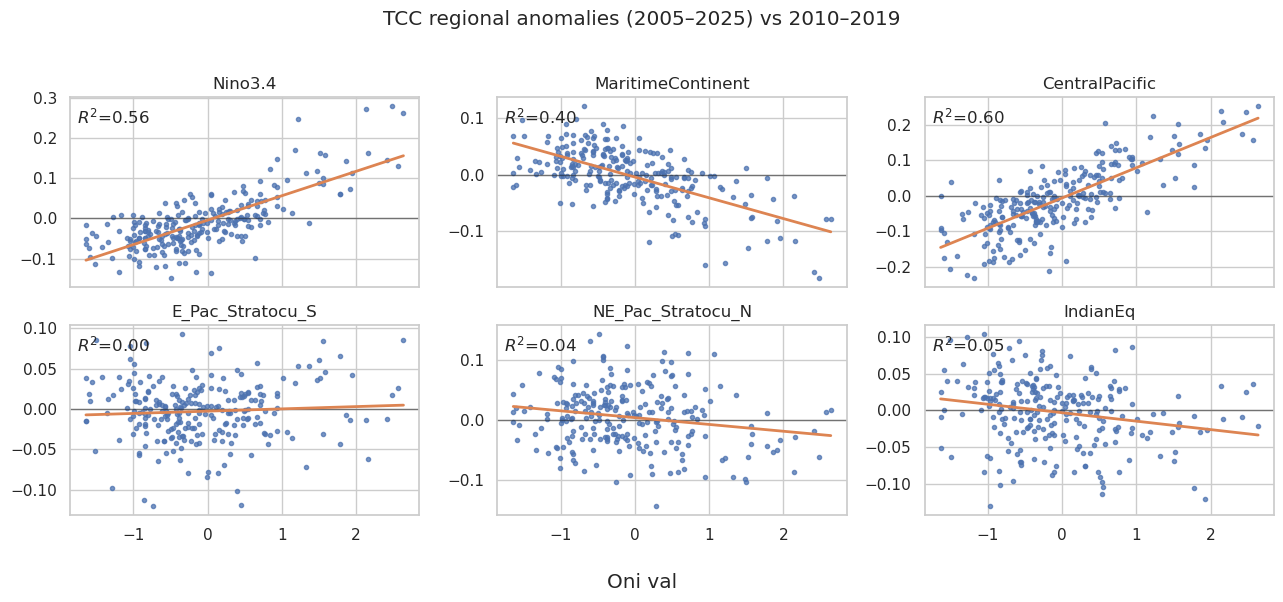

In [12]:
#!/usr/bin/env python3
"""
Regional ERA5 TCC anomalies (area-weighted) with ENSO colouring.

- Reads monthly single-level NetCDFs with 'valid_time' (seconds since 1970-01-01)
- Computes regional area-weighted monthly means of TCC
- Builds 2010–2019 monthly climatology (configurable) *per region*
- Produces anomalies for a chosen analysis window
- Colours points by ENSO state from an ONI CSV (two columns: Date, ONI)

Outputs:
  - CSVs: regional_means_*, regional_anomalies_*
  - PNG: tcc_regional_anoms_<start>_<end>.png
"""

import glob, numpy as np, pandas as pd
from pathlib import Path
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from math import ceil

# =========================
# CONFIG — edit these only
# =========================
ANALYSIS_START = 2005
ANALYSIS_END   = 2025

# Baseline for monthly climatology (used for anomalies)
CLIM_START = 2010
CLIM_END   = 2019

# ENSO threshold for ONI (°C)
ENSO_THRESH = 0.5

# If True and land_sea_mask/lsm is present, use OCEAN ONLY (lsm < 0.5)
OCEAN_ONLY = False

# NetCDF folder and ONI file (two columns: Date, ONI)
indir = Path("era5_monthly_nc")
oni_csv = "oni.csv"

# Variable/coord name candidates
VAR_TCC   = ["tcc", "total_cloud_cover"]
LAT_CANDS = ["latitude", "lat"]
LON_CANDS = ["longitude", "lon"]
TIME_CANDS= ["valid_time", "time"]
LSM_CANDS = ["land_sea_mask", "lsm"]  # fraction land (0 ocean, 1 land)

# Regions (lat_min, lat_max, lon_min, lon_max) — lon can be in −180..180 or 0..360
REGIONS = {
    "Nino3.4":            (-5,   5,  -170,  -120),  # 5S–5N, 170W–120W
    "MaritimeContinent":  (-10, 10,   100,   150),  # 10S–10N, 100E–150E
    "CentralPacific":     (-5,   5,   160,   -150), # 160E–150W (wrap)
    "E_Pac_Stratocu_S":   (-25, -5,  -100,   -80),  # SEP stratocu
    "NE_Pac_Stratocu_N":  (15,  30,  -140,  -120),  # NEP stratocu
    "IndianEq":           (-10, 10,    60,   100),  # Equatorial Indian
}
# =========================================================

def pick(nc, candidates):
    for v in candidates:
        if v in nc.variables:
            return v
    return None

def area_weights(lat, lon):
    wlat = np.cos(np.deg2rad(lat))
    return np.broadcast_to(wlat[:, None], (len(lat), len(lon)))

def to0360(lon_vals):
    return np.mod(lon_vals, 360.0)

def bounds_to_0360(lmin, lmax):
    return (lmin % 360.0, lmax % 360.0)

def lon_mask_0360(lon_axis_0360, lo0360, hi0360):
    # supports wrap-around (e.g., 350..20)
    if lo0360 <= hi0360:
        return (lon_axis_0360 >= lo0360) & (lon_axis_0360 <= hi0360)
    else:
        return (lon_axis_0360 >= lo0360) | (lon_axis_0360 <= hi0360)

def region_mask(lat, lon, lat_min, lat_max, lon_min, lon_max):
    """2D boolean mask for region bounds. Handles lon wrap and lon conventions."""
    # Ensure increasing bounds
    la0, la1 = (lat_min, lat_max) if lat_min <= lat_max else (lat_max, lat_min)
    lat_m = (lat >= la0) & (lat <= la1)

    # Put lon axis and bounds into 0..360 for robust selection
    lon0360 = to0360(lon.copy())
    lo0360, hi0360 = bounds_to_0360(lon_min, lon_max)
    lon_m = lon_mask_0360(lon0360, lo0360, hi0360)

    return lat_m[:, None] & lon_m[None, :]

def weighted_mean_region(data2d, w2d, mask2d):
    mask = np.isfinite(data2d) & mask2d
    if not np.any(mask):
        return np.nan
    w = w2d * mask
    return np.nansum(w * data2d) / np.nansum(w)

# -------------------------------
# Build file list (include clim years)
# -------------------------------
FILE_START = min(ANALYSIS_START, CLIM_START)
FILE_END   = max(ANALYSIS_END,   CLIM_END)
patterns = [f"era5_single_levels_monthly_{y}*.nc" for y in range(FILE_START, FILE_END+1)]
files = sorted({f for pat in patterns for f in glob.glob(str(indir / pat))})
if not files:
    raise FileNotFoundError(f"No files in {indir} for {FILE_START}-{FILE_END}")

# -------------------------------
# Loop files → regional means
# -------------------------------
records = []
for f in files:
    with Dataset(f) as nc:
        vlat = pick(nc, LAT_CANDS); vlon = pick(nc, LON_CANDS)
        if vlat is None or vlon is None:
            raise KeyError(f"lat/lon not found in {f}")
        lat = np.array(nc.variables[vlat][:], dtype=float)
        lon = np.array(nc.variables[vlon][:], dtype=float)
        w2d = area_weights(lat, lon)

        # Optional ocean-only mask
        ocean_mask = None
        if OCEAN_ONLY:
            vlsm = pick(nc, LSM_CANDS)
            if vlsm is not None:
                lsm = np.array(nc.variables[vlsm][...], dtype=float)
                # Make 2D
                if lsm.ndim == 3:
                    lsm = lsm[0, ...]
                ocean_mask = (lsm < 0.5)

        # Precompute region masks for this grid
        region_masks = {}
        for rname, (la0, la1, lo0, lo1) in REGIONS.items():
            m = region_mask(lat, lon, la0, la1, lo0, lo1)
            if OCEAN_ONLY and ocean_mask is not None:
                m = m & ocean_mask
            region_masks[rname] = m

        # Time and TCC var
        vtime = pick(nc, TIME_CANDS)
        if vtime is None:
            raise KeyError(f"time var not found in {f} (looked for {TIME_CANDS})")
        times = pd.to_datetime(np.asarray(nc.variables[vtime][:], dtype="int64"),
                               unit="s", utc=True).tz_localize(None)

        vtcc = pick(nc, VAR_TCC)
        if vtcc is None:
            raise KeyError(f"TCC not found in {f} (candidates {VAR_TCC})")

        for it, ts in enumerate(times):
            rec = {"time": ts, "year": ts.year, "month": ts.month}
            tcc2d = np.array(nc.variables[vtcc][it, ...], dtype=float)
            for rname, m in region_masks.items():
                rec[f"{rname}"] = weighted_mean_region(tcc2d, w2d, m)
            records.append(rec)

# -------------------------------
# Tidy to MultiIndex table
# -------------------------------
df = pd.DataFrame.from_records(records).set_index("time").sort_index()
# average duplicates if any
df = df.groupby([df.index.year, df.index.month]).mean()
df.index.names = ["year", "month"]
# drop any leftover 'year','month' columns from aggregation
for col in ("year", "month"):
    if col in df.columns:
        df = df.drop(columns=col)

# Save raw regional means (full span)
out_means = f"regional_means_{FILE_START}_{FILE_END}.csv"
df.to_csv(out_means, float_format="%.6g")
print(f"Saved {out_means}")

# -------------------------------
# Build anomalies per region
# -------------------------------
idx = pd.IndexSlice
df_in = df.loc[idx[ANALYSIS_START:ANALYSIS_END, 1:12], :]

clim_src = df.loc[idx[CLIM_START:CLIM_END, 1:12], :]
if clim_src.empty:
    print(f"WARNING: No data for baseline {CLIM_START}-{CLIM_END}. "
          f"Using available years {FILE_START}-{FILE_END} as baseline.")
    clim_src = df

anom = df_in.copy()
months = anom.index.get_level_values("month")

for col in df.columns:
    clim_month = clim_src[col].groupby(level="month").mean()
    # map month → climatology value for that region
    anom[col] = df_in[col].values - months.map(clim_month).values

# Save anomalies
out_anoms = f"regional_anomalies_{ANALYSIS_START}_{ANALYSIS_END}.csv"
anom.reset_index().to_csv(out_anoms, index=False, float_format="%.6g")
print(f"Saved {out_anoms}")

# -------------------------------
# ENSO labels from ONI (two columns: Date, ONI; some rows may be headers or -9999)
# -------------------------------
oni_raw = pd.read_csv(oni_csv, header=None, names=["date", "oni"])
oni_raw["date"] = pd.to_datetime(oni_raw["date"], format="%Y-%m-%d",errors="coerce")
oni_raw["oni"]  = pd.to_numeric(oni_raw["oni"], errors="coerce")
oni = oni_raw.dropna(subset=["date"]).copy()
oni.loc[oni["oni"] <= -99, "oni"] = np.nan  # treat sentinels as missing
oni["year"]  = oni["date"].dt.year
oni["month"] = oni["date"].dt.month
oni = oni.set_index(["year", "month"]).sort_index()

oni_vals = oni.reindex(anom.index)["oni"]
state = pd.Series(index=anom.index, dtype="string")
state[(oni_vals >=  ENSO_THRESH).fillna(False)] = "ElNino"
state[(oni_vals <= -ENSO_THRESH).fillna(False)] = "LaNina"
state[state.isna()] = "Neutral"

# -------------------------------
# Print composites (mean anomaly per ENSO phase, by region)
# -------------------------------
comp = anom.join(state.rename("state")).groupby("state").mean()
comp = comp.reindex(["ElNino", "Neutral", "LaNina"])
print("\nRegional mean TCC anomalies by ENSO phase:")
print(comp)

# -------------------------------
# Plot: per-region anomalies coloured by ENSO
# -------------------------------
months_labels = [f"{y}-{m:02d}" for y, m in anom.index]
x = np.arange(len(months_labels))
col_map = {"ElNino": "tab:red", "Neutral": "tab:gray", "LaNina": "tab:blue"}

region_names = list(REGIONS.keys())
nreg = len(region_names)
ncol = 3
nrow = int(ceil(nreg / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(13, 3.0*nrow), sharex=True)
axes = np.array(axes).reshape(nrow, ncol)

for i, r in enumerate(region_names):
    ax = axes[i // ncol, i % ncol]
    y = anom[r].values
    x = np.asarray(oni_vals)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # Scatter
    ax.plot(x, y, '.', alpha=0.75)
    # Zero line
    ax.axhline(0, lw=1, color='k', alpha=0.5)
    ax.set_title(r)
    ax.grid(True)

    # Fit & R^2 (only if we have 2+ points)
    if x.size >= 2:
        slope, intercept, r_val, p_val, stderr = stats.linregress(x, y)
        xfit = np.linspace(x.min(), x.max(), 100)
        yfit = intercept + slope * xfit
        ax.plot(xfit, yfit, lw=2)  # fitted line
        # Annotate R^2 in the top-left corner inside the axes
        ax.text(0.02, 0.95, f"$R^2$={r_val**2:.2f}",
                transform=ax.transAxes, va='top', ha='left')

fig.supxlabel('Oni val')

# Hide any empty subplot slots
for j in range(nreg, nrow*ncol):
    axes[j // ncol, j % ncol].set_visible(False)

# # reasonable tick density
# step = max(1, len(x)//18)
# for ax in axes[-1, :]:
#     ax.set_xticks(x[::step])
#     ax.set_xticklabels(months_labels[::step], rotation=90)

fig.suptitle(f"TCC regional anomalies ({ANALYSIS_START}–{ANALYSIS_END}) vs {CLIM_START}–{CLIM_END}")
fig.tight_layout(rect=[0, 0, 1, 0.96])
out_png = f"tcc_regional_anoms_correl_{ANALYSIS_START}_{ANALYSIS_END}.png"
plt.savefig(out_png, dpi=140)
print(f"Saved {out_png}")

## 5. Autocorrelation (from original script)


Correlation with ONI (monthly, anomalies), adj. for autocorr:
           region      r  r_lo95  r_hi95  slope_per_ONI  p_adj
          Nino3.4  0.750   0.571   0.861          0.061  0.000
MaritimeContinent -0.631  -0.746  -0.479         -0.037  0.000
   CentralPacific  0.777   0.623   0.873          0.085  0.000
 E_Pac_Stratocu_S  0.066  -0.110   0.238          0.003  0.463
NE_Pac_Stratocu_N -0.192  -0.333  -0.043         -0.011  0.012
         IndianEq -0.216  -0.330  -0.097         -0.012  0.000
Saved tcc_region_lag_correlations.png

Seasonal correlation (DJF/JJA):
           region season      r  n_eff
          Nino3.4    DJF  0.824 33.429
          Nino3.4    JJA  0.746 28.085
MaritimeContinent    DJF -0.678 52.234
MaritimeContinent    JJA -0.358 46.054
   CentralPacific    DJF  0.843 35.161
   CentralPacific    JJA  0.761 44.225
 E_Pac_Stratocu_S    DJF  0.398 39.557
 E_Pac_Stratocu_S    JJA -0.090 42.190
NE_Pac_Stratocu_N    DJF -0.337 45.938
NE_Pac_Stratocu_N    JJA -0.142 69.

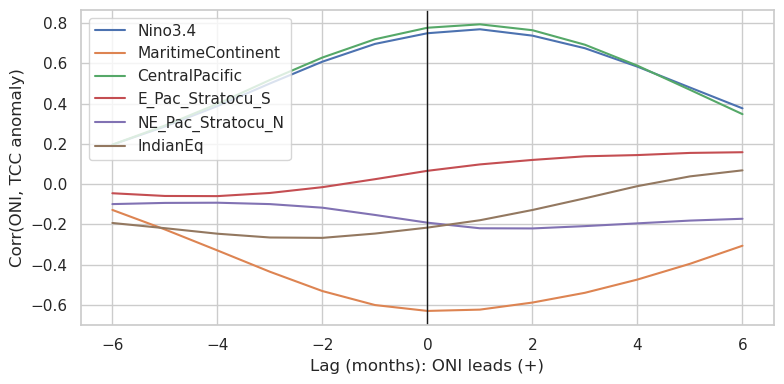

In [13]:
# --- CONFIG: which regions to test ---
REGIONS_TO_TEST = ["Nino3.4", "MaritimeContinent", "CentralPacific", "E_Pac_Stratocu_S", "NE_Pac_Stratocu_N", "IndianEq"]

import numpy as np, pandas as pd
from math import atanh, tanh, sqrt
from scipy import stats
import matplotlib.pyplot as plt

# Align ONI with anomalies
oni_aligned = oni.reindex(anom.index)["oni"]
X = oni_aligned  # predictor
results = []

def eff_sample_size(x, y, maxlag=1):
    """Bretherton-style N_eff using lag-1 autocorr of x and y (or up to maxlag)."""
    x = pd.Series(x).dropna(); y = pd.Series(y).dropna()
    xy = pd.concat([x, y], axis=1).dropna()
    if len(xy) < 3:
        return len(xy)
    # simple AR(1) estimate
    def r1(z):
        z = z - z.mean()
        return np.corrcoef(z[:-1], z[1:])[0,1] if len(z) > 2 else 0.0
    rx = r1(xy.iloc[:,0].values)
    ry = r1(xy.iloc[:,1].values)
    n = len(xy)
    return n * (1 - rx*ry) / (1 + rx*ry)

def corr_ci(r, n_eff, alpha=0.05):
    if n_eff <= 3 or np.isnan(r):
        return (np.nan, np.nan)
    z = atanh(np.clip(r, -0.999999, 0.999999))
    se = 1.0 / sqrt(max(1.0, n_eff - 3))
    zc = stats.norm.ppf(1 - alpha/2)
    lo, hi = z - zc*se, z + zc*se
    return (tanh(lo), tanh(hi))

for reg in REGIONS_TO_TEST:
    y = anom[reg]
    df_xy = pd.concat([X, y], axis=1).dropna()
    if df_xy.empty:
        results.append((reg, np.nan, np.nan, np.nan, np.nan, np.nan)); continue
    x = df_xy.iloc[:,0].values
    yy = df_xy.iloc[:,1].values

    # Pearson r
    r = np.corrcoef(x, yy)[0,1]
    n_eff = eff_sample_size(x, yy)
    # p-value using Student-t with df = n_eff-2
    if n_eff > 2 and not np.isnan(r):
        tstat = r * sqrt((n_eff - 2) / (1 - r**2 + 1e-15))
        pval = 2 * (1 - stats.t.cdf(abs(tstat), df=max(1, int(round(n_eff - 2)))))
    else:
        pval = np.nan
    lo, hi = corr_ci(r, n_eff)

    # slope (OLS): ΔTCC per 1 °C ONI
    slope, intercept, _, _, _ = stats.linregress(x, yy)

    results.append((reg, r, lo, hi, slope, pval))

corr_table = pd.DataFrame(results, columns=["region","r","r_lo95","r_hi95","slope_per_ONI","p_adj"])
print("\nCorrelation with ONI (monthly, anomalies), adj. for autocorr:")
print(corr_table.to_string(index=False, float_format=lambda v: f"{v:.3f}"))

# -------- OPTIONAL: lead/lag correlation curves --------
DO_LAG_CURVES = True
if DO_LAG_CURVES:
    maxlag = 6
    lags = np.arange(-maxlag, maxlag+1)
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    for reg in REGIONS_TO_TEST:
        series = []
        for L in lags:
            if L >= 0:
                xL = X.shift(L); yL = anom[reg]
            else:
                xL = X; yL = anom[reg].shift(-L)
            df_xy = pd.concat([xL, yL], axis=1).dropna()
            if len(df_xy) < 6:
                series.append(np.nan); continue
            rL = np.corrcoef(df_xy.iloc[:,0].values, df_xy.iloc[:,1].values)[0,1]
            series.append(rL)
        ax.plot(lags, series, label=reg)
    ax.axvline(0, color="k", lw=1)
    ax.set_xlabel("Lag (months): ONI leads (+)")
    ax.set_ylabel("Corr(ONI, TCC anomaly)")
    ax.grid(True); ax.legend()
    plt.tight_layout(); plt.savefig("tcc_region_lag_correlations.png", dpi=140)
    print("Saved tcc_region_lag_correlations.png")

# -------- OPTIONAL: seasonal correlations (DJF vs JJA) --------
DO_SEASONS = True
if DO_SEASONS:
    season = pd.Series(index=anom.index, dtype="string")
    # simple DJF/JJA tags (others = shoulder seasons)
    months = anom.index.get_level_values("month")
    season[(months==12) | (months<=2)] = "DJF"
    season[(months>=6) & (months<=8)]  = "JJA"

    out = []
    for reg in REGIONS_TO_TEST:
        for s in ["DJF","JJA"]:
            mask = (season==s)
            df_xy = pd.concat([X[mask], anom[reg][mask]], axis=1).dropna()
            if len(df_xy) < 6:
                out.append((reg, s, np.nan, np.nan)); continue
            r = np.corrcoef(df_xy.iloc[:,0], df_xy.iloc[:,1])[0,1]
            n_eff = eff_sample_size(df_xy.iloc[:,0], df_xy.iloc[:,1])
            lo, hi = corr_ci(r, n_eff)
            out.append((reg, s, r, n_eff))
    seas_tbl = pd.DataFrame(out, columns=["region","season","r","n_eff"])
    print("\nSeasonal correlation (DJF/JJA):")
    print(seas_tbl.to_string(index=False, float_format=lambda v: f"{v:.3f}"))
